<H3>PRI 2023/24: second
    project delivery</H3>

**GROUP 08**
- Daniele Avolio    , ist1111559
- Michele Vitale	, ist1111558	
- Luís Dias	        , ist198557

<H2>Main facilities</H2>

<h3>Part I: clustering</h3>

*A) Clustering*

This function takes a document, along with optional inverted index and clustering arguments, and returns the best clustering solution for the given task, determined by proper internal indices.

In [1]:
# Imports useful later

import os
import sys
import time
import random
import nltk
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn import cluster 
from sklearn import model_selection
from sklearn.feature_extraction.text import TfidfVectorizer



In [63]:
import os  


def read_files(location:str, skip_first_line:bool=True) -> list:
    """
    Read all text files in the specified location and return their contents as a list.
    """
    files_list = []
    
    for root, dirs, files in os.walk(location):
        for file in files:
            if file.endswith(".txt"): 
                with open(os.path.join(root, file), "r") as auto:
                    if skip_first_line: auto.readline()
                    # Skip the first line
                    files_list.append(auto.read().strip())
    return files_list

We will get those from the beginning, so we won't have problems in the future.

In [64]:
documents = read_files("../BBC News Summary/News Articles")
summaries = read_files("../BBC News Summary/Summaries", skip_first_line=False)

In [65]:
print(documents[0])
print()
print(summaries[0])


Ad sales boost Time Warner profit

Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (Â£600m) for the three months to December, from $639m year-earlier.

The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.

Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AO

In [401]:
# hierarchical clustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score


def sentence_clustering(d: str, I: None, **kwargs):
    # Workflow idea:
    # 1. Split the document into sentences using nltk
    # 2. Convert the sentences into vectors using TfIdf
    # 3. Cluster the vectors using Hierarchical Clustering
    # 4. Return the clusters

    # Problems: How many clusters should we use?
    # Answer: We can use the elbow method to find the optimal number of clusters

    # Problems: How do we know if the clusters are good?
    # Answer: We can use the silhouette score to evaluate the quality of the clusters
    text = d

    sentences = nltk.sent_tokenize(text)

    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(sentences)

    # Best number of clusters
    best_silhouette_score = -1
    best_c_score = -1
    best_n_clusters = 0

    for n_clusters in range(2, min(len(sentences), 11)):
        model = AgglomerativeClustering(
            n_clusters=n_clusters, linkage="complete", metric="cosine"
        )
        labels = model.fit_predict(X.toarray())

        # Calculate the silhouette score, which measures the compactness and separation of the clusters.
        # A higher silhouette score indicates better clustering quality.
        # It ranges from -1 to 1, with 1 being the best score.
        # The goal is to maximize the silhouette score.
        # Reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

        silhouette_score_value = silhouette_score(X.toarray(), labels)

        # Calculate the Calinski-Harabasz score, which measures the ratio of between-cluster dispersion to within-cluster dispersion.
        # A higher Calinski-Harabasz score indicates better clustering quality.
        # It is based on the analysis of variance (ANOVA) and measures the separation between clusters.
        # The goal is to maximize the Calinski-Harabasz score.
        # Reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabasz_score.html
        c_score = calinski_harabasz_score(X.toarray(), labels)

        if silhouette_score_value > best_silhouette_score and c_score > best_c_score:
            best_silhouette_score = silhouette_score_value
            best_c_score = c_score
            best_n_clusters = n_clusters
    # print(f"Numero ottimale di cluster: {best_n_clusters}")

    model = AgglomerativeClustering(
        n_clusters=best_n_clusters, linkage="complete", metric="cosine"
    )
    labels = model.fit_predict(X.toarray())

    # 5. Costruisci la soluzione di clustering
    cluster_solution = {}
    for i, label in enumerate(labels):
        if label not in cluster_solution:
            cluster_solution[label] = []
        cluster_solution[label].append(sentences[i])

    return cluster_solution

In [402]:
sentence_clustering(documents[0], None)

{2: ['Ad sales boost Time Warner profit\n\nQuarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (Â£600m) for the three months to December, from $639m year-earlier.',
  'Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.',
  'TimeWarner also has to restate 2000 and 2003 results following a probe by the US Securities Exchange Commission (SEC), which is close to concluding.',
  'But its film division saw profits slump 27% to $284m, helped by box-office flops Alexander and Catwoman, a sharp contrast to year-earlier, when the third and final film in the Lord of the Rings trilogy boosted results.',
  'For the full-year, TimeWarner posted a profit of $3.36bn, up 27% from its 2003 performance, while revenues grew 6.4% to $42.09bn.',
  'For 2005, TimeWarner is projecting operating earnings growth of around 5%, and also expects higher revenue and wider profit margins.',
  'TimeWarner is to restate its accounts as part of eff

We will create a functio to visualize the clusters, and another to visualize the dendrogram.

In [405]:

from sklearn.decomposition import PCA

def plot_clusters(clusters:dict, return_plot:bool=False):
    # Get the vector space from the clusters
    values = clusters.values()

    # Convert the sentences into vectors using TfIdf
    vectorizer = TfidfVectorizer()
    sentences = [sentence for cluster in values for sentence in cluster]
    
    X = vectorizer.fit_transform(sentences)

    # Reduce the dimensionality of the vectors to 2D
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X.toarray())

    # Plot the clusters and set the color 
    # knowing that the keys of the clusters are the labels and the 
    # values are the sentences

    for key, value in clusters.items():
        plt.scatter(X_pca[[sentences.index(sentence) for sentence in value], 0], 
                    X_pca[[sentences.index(sentence) for sentence in value], 1], 
                    label=f"Cluster {key}")

    if return_plot: return plt
    
    # Plot the confidence ellipses
    plt.legend()
    plt.show()




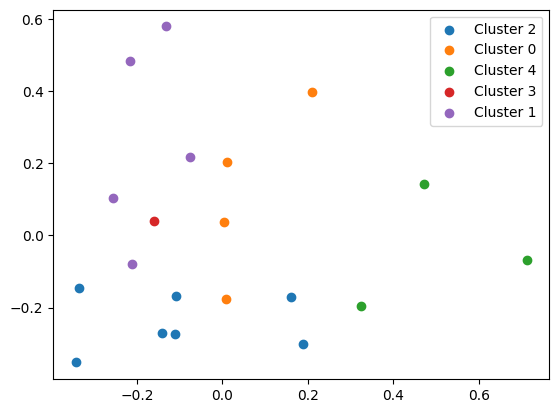

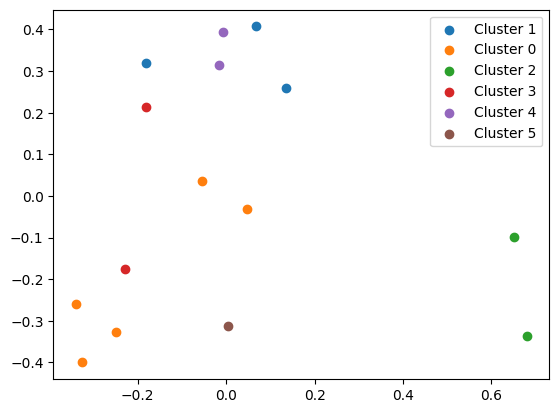

In [406]:
docs = documents[:2]

for doc in docs:
    clusters = sentence_clustering(doc, None)
    plot_clusters(clusters)

*B) Summarization*

In [ ]:
#code, statistics and/or charts here

*C) Keyword extraction*

In [3]:
#code, statistics and/or charts here

*D) Evaluation*

In [ ]:
#code, statistics and/or charts here

<h3>Part II: classification</h3>

*A) Feature extraction*

In [ ]:
#code and statistics here

*B) Classification*

In [4]:
#code here

*C) Ranking extension*

In [4]:
#code here

*D) Evaluation*

In [5]:
#code, statistics and/or charts here

<H2>Question materials (optional)</H2>

<H3>Part I: clustering</H3>

**(1)** Do clustering-guided summarization alters the behavior and efficacy of the IR system?

In [ ]:
#code, statistics and/or charts here

**(2)** How sentence representations, clustering choices, and rank criteria impact summarization?

In [ ]:
#code, statistics and/or charts here

**...** (additional questions with empirical results)

<H3>END</H3>